# Distribution of swept regions and enrichments in sweeps

In [1]:
import re, os, sys, pickle, pickle
from pathlib import Path
import numpy
import pandas
from pandas import DataFrame, Series
from sklearn.decomposition import PCA

# my own libaries
from ChromosomeWindows import window

numpy.random.seed(7)

Plotting setup:

In [2]:
%matplotlib inline

# Make inline plots vector graphics instead of raster graphics
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('retina', 'png')

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib.patches import Rectangle
from matplotlib.lines import Line2D 
#from mpl_toolkits.basemap import Basemap
#matplotlib.rcParams['figure.figsize'] = (20.0, 10.0)

import mpld3

import seaborn as sns
sns.set() # sets seaborn default "prettyness:
sns.set_style("whitegrid")
sns.set_context("paper")

# lowess for plotting
from statsmodels.nonparametric.smoothers_lowess import lowess

set1 = {'red': '#e41a1c', 'blue': '#377eb8', 'green': '#4daf4a',
        'purple': '#984ea3', 'orange': '#ff7f00', 
        'yellow': '#ffff33', 'brown': '#a65628'}

Ignore deprecation warnings from mainly seaborn:

In [3]:
# silence deprecation warnings (lots from seaborn)
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 
warnings.filterwarnings("ignore", category=numpy.VisibleDeprecationWarning)

Analysis dirs:

In [4]:
root_dir = Path(os.environ['HOME'], 'simons/faststorage/people/kmt')
meta_data_dir = Path(os.environ['HOME'], 'simons/faststorage/data/metadata')
steps_dir = root_dir / 'steps'
argweaver_dir = steps_dir / 'argweaver/output'
results_dir = root_dir / 'results'
figures_dir = root_dir / 'figures'
data_dir = root_dir / 'data'
pi_dir = steps_dir / 'pi_stores'
dist_dir = steps_dir / 'dist_stores'
#pi_dir = root_dir / 'old_pi_stores'
male_x_haploid_dir = steps_dir / 'male_x_haploids'

Local code in the scripts dir on the cluster:

In [5]:
scripts_dir = root_dir / 'scripts'
if str(scripts_dir) not in sys.path:
    sys.path.append(str(scripts_dir))

import simons_meta_data
import hg19_chrom_sizes

from toggle_code_and_errors import toggle_code_html, toggle_errors_html

Import variables global to the entire analysis:

In [6]:
import analysis_globals

## Convenience functions

In [7]:
def silent_nanmean(x):
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        return numpy.nanmean(x)
    
def ident_scalar(s):
    x = s.unique()
    assert(len(x)) == 1, x
    return x[0]

from multiprocessing import Pool, cpu_count

# def cpu_count():
#     return int(os.environ['SLURM_CPUS_PER_TASK'])

def parallel_apply(grouped, func, *args, chunksize=None):
    names, groups = zip(*grouped)
    arg_iter = zip(groups, *[[x]*len(groups) for x in args])
    
    slurm_cores = os.environ.get('SLURM_JOB_NUM_NODES')
    nr_cpu = slurm_cores and int(slurm_cores) or cpu_count()

    with Pool(nr_cpu) as p:
        l = p.starmap(func, arg_iter, chunksize=chunksize)
        
    df = pandas.concat(l, keys=names)
    df.reset_index(level=df.index.nlevels-1, drop=True, inplace=True)
    return df

## Load meta data

In [8]:
# easy loading of meta data in a consistent manner across code
individuals, populations, regions = simons_meta_data.get_meta_data(meta_data_dir=meta_data_dir)

pop_categories = pandas.read_hdf(str(results_dir / 'population_categories.store'), 'sr')
region_categories = pandas.read_hdf(str(results_dir / 'region_categories.store'), 'sr')
# region_colors = dict(zip(list(region_categories), 
#                          ['#e41a1c', '#377eb8', '#4daf4a', '#984ea3', 
#                           '#ff7f00', '#ffff33', '#a65628']))

region_colors = dict(zip(list(region_categories), 
                         ['#e41a1c', '#377eb8',  '#984ea3', '#4daf4a',
                          '#ff7f00', '#ffff33', '#a65628']))

chromosome_lengths = dict((k.replace('chr', ''), v) for k, v in hg19_chrom_sizes.hg19_chrom_sizes.items())

## Separate region legends for plots

In [9]:
fig = plt.figure()
plt.axis('off')
ax = plt.gca()
legend_elements = [Line2D([0], [0], marker='o', color='white', markersize=10, 
                          label=reg, markerfacecolor=region_colors[reg]) for reg in region_categories]
ax.legend(handles=legend_elements, loc='lower left')
plt.tight_layout()
plt.savefig(str(figures_dir / 'legend1column.pdf'))
plt.close()

In [10]:
fig = plt.figure(figsize=(10,2))
plt.axis('off')
ax = plt.gca()
legend_elements = [Line2D([0], [0], marker='o', color='white', markersize=10, 
                          label=reg, markerfacecolor=region_colors[reg]) for reg in region_categories]
ax.legend(handles=legend_elements, loc='lower left', ncol=7)
plt.tight_layout()
plt.savefig(str(figures_dir / 'legend7column.pdf'))
plt.close()

In [11]:
fig = plt.figure(figsize=(10,2))
plt.axis('off')
ax = plt.gca()
legend_elements = [Line2D([0], [0], marker='o', color='white', markersize=10, 
                          label=reg, markerfacecolor=region_colors[reg]) for reg in region_categories]
ax.legend(handles=legend_elements, loc='lower left', ncol=3)
plt.tight_layout()
plt.savefig(str(figures_dir / 'legend3column.pdf'))
plt.close()

## Load pairwise distance data

In [12]:
all_male_dist_twice = pandas.read_hdf(steps_dir / 'male_dist_admix_masked_stores/male_dist_data_chrX_100kb_twice.hdf')

## Read in sweep data

See `scripts/clique_calling.py` for how sweeps are called.

In [13]:
# df1 = pandas.read_hdf(steps_dir / 'male_dist_admix_masked_stores/5e-05/sweep_data_5e-05_30%.hdf')
# df2 = pandas.read_hdf(steps_dir / 'male_dist_admix_masked_stores/5e-05/clique_data_5e-05_30%.hdf')

In [14]:
# df1.loc[df1.called == True].shape, df2.loc[df2.called == True].shape

In [15]:
# df1.loc[df1.clade_size > 90].shape, df2.loc[df2.clade_size > 90].shape

In [16]:
# s = df2.groupby(['start', 'clade_size']).apply(lambda df: df.indiv_1.unique().size).reset_index()
# s

In [17]:
# sweep_data = pandas.read_hdf(steps_dir / 'male_dist_admix_masked_stores/sweep_data_5e-05_42.hdf')

sweep_data = pandas.read_hdf(steps_dir / 'male_dist_admix_masked_stores/5e-05/clique_data_5e-05_25%.hdf')
#sweep_data = pandas.read_hdf('/home/kmt/simons/faststorage/people/kmt/test.hdf')

# sweep_data = pandas.read_hdf(steps_dir / 'male_dist_admix_masked_stores/5e-05/sweep_data_5e-05_26%.hdf')

In [18]:
sweep_data.indiv_1.unique().size

162

## Distributions of dist between haplotypes

The mean distance to other individuals in the sweep clade for each swept individual:

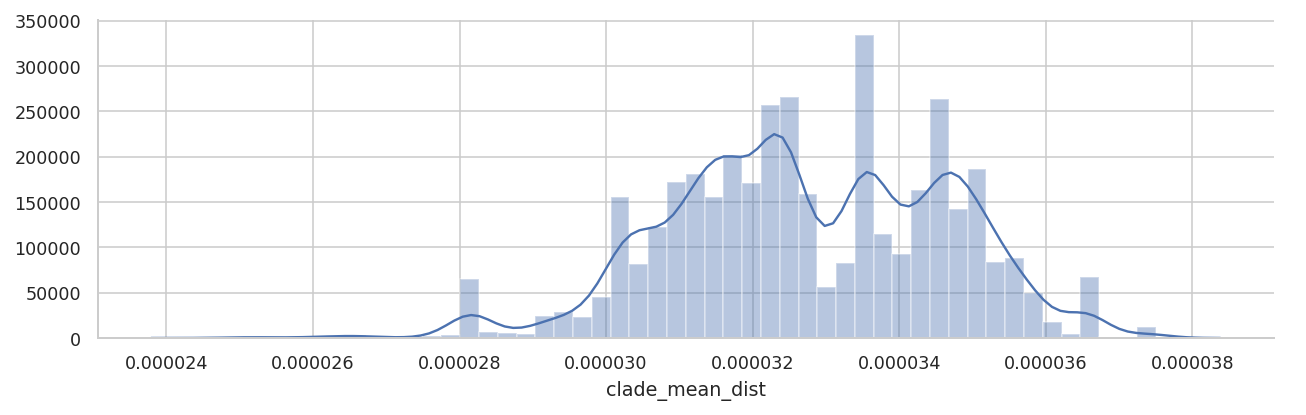

In [19]:
with sns.axes_style('whitegrid'):
    g = sns.FacetGrid(data=sweep_data, #hue='swept', 
                      aspect=3)
    g = g.map(sns.distplot, 'clade_mean_dist')
    g = g.add_legend()

The mean distance to all other individuals for each swept individual:

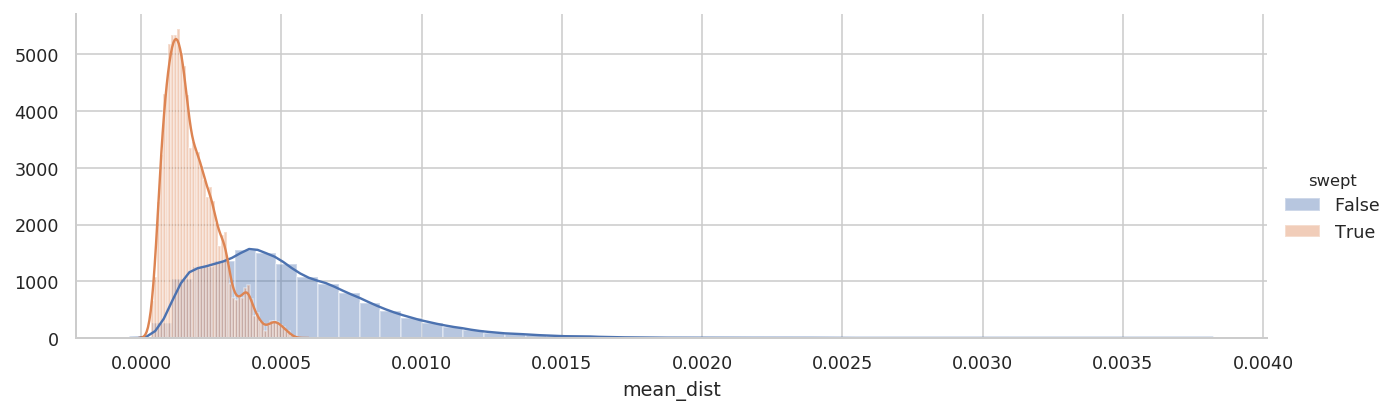

In [20]:
with sns.axes_style('whitegrid'):
    g = sns.FacetGrid(data=sweep_data, hue='swept', aspect=3)
    g = g.map(sns.distplot, 'mean_dist')
    g = g.add_legend()

## Windows where distances to other individuals are incompletely known

100kb windows:

In [21]:
print('Max proportion of uncalled individuals:', analysis_globals.max_prop_indiv_missing)

Max proportion of uncalled individuals: 0.1


In [22]:
sweep_data.prop_indivs_missing.describe()

count    251424.000000
mean          0.109371
std           0.310451
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           1.000000
Name: prop_indivs_missing, dtype: float64

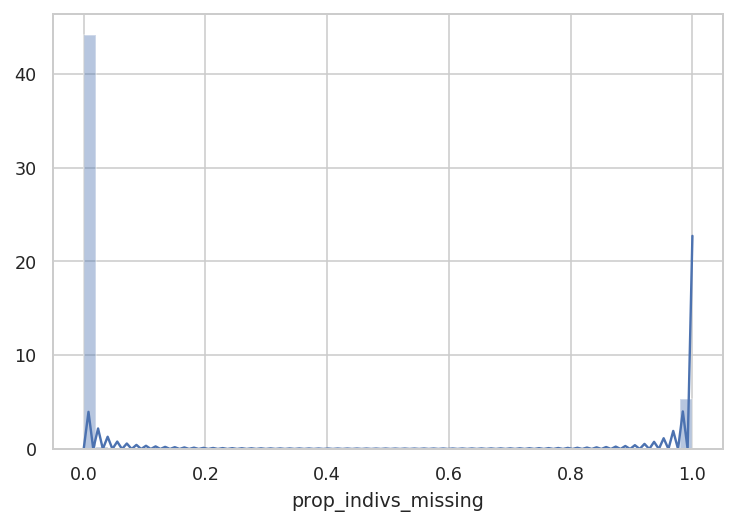

In [23]:
g = sns.distplot(sweep_data.prop_indivs_missing)

In [24]:
missing_indiv_window_mask = sweep_data.prop_indivs_missing <= analysis_globals.max_prop_indiv_missing
print('Proportion of 100kb windows left after filtering:', missing_indiv_window_mask.sum() / missing_indiv_window_mask.size)

sweep_data['not_missing'] = missing_indiv_window_mask

Proportion of 100kb windows left after filtering: 0.8888928662339315


## Pi for entire chrom and when excluding haplotypes called as swept

In [25]:
#all_male_dist_twice = pandas.read_hdf(analysis_globals.results_dir / 'all_male_dist_twice.hdf')

In [26]:
#sweep_data = pandas.read_hdf(analysis_globals.results_dir / 'sweep_data.hdf')

In [27]:
df = (all_male_dist_twice
      .loc[(all_male_dist_twice.region_label_1 != 'Africa') & (all_male_dist_twice.region_label_2 != 'Africa'),
          ['start', 'indiv_1', 'indiv_2', 'dist']]
      .merge(sweep_data[['start', 'indiv_1', 'swept']], on=['start', 'indiv_1'], how='left')
     )

In [28]:
(df.loc[df.swept != True].dist.mean(), df.dist.mean(), 
    df.loc[df.swept == True].dist.mean() / df.dist.mean(), 
    df.dist.mean() / df.loc[df.swept != True].dist.mean()
)

(0.00045658665, 0.00043342708, 0.3037549, 0.9492767)

It seems pi only increases a little when sweept haplotypes are removed. Which makes sense if their average diversity is 38% of global average and since they only account for a relatively small part of all haplotypes.

## Proportion of missing windows across chromosome

In [29]:
missing_windows = (sweep_data
                            .groupby(['start', 'end'])['prop_indivs_missing']
                            .mean()
                            .reset_index()
                            .rename(columns={'prop_indivs_missing': 'mean_prop_indivs_missing'})
                           )
missing_windows['is_missing'] = missing_windows.mean_prop_indivs_missing >= analysis_globals.max_prop_indiv_missing

Write missing windows to hdf:

In [30]:
missing_windows.to_hdf(results_dir / 'missing_windows.hdf', 'df', format='table', mode='w')
missing_windows.head()

,start,end,mean_prop_indivs_missing,is_missing
0,0,100000,1.0,True
1,100000,200000,1.0,True
2,200000,300000,1.0,True
3,300000,400000,1.0,True
4,400000,500000,1.0,True


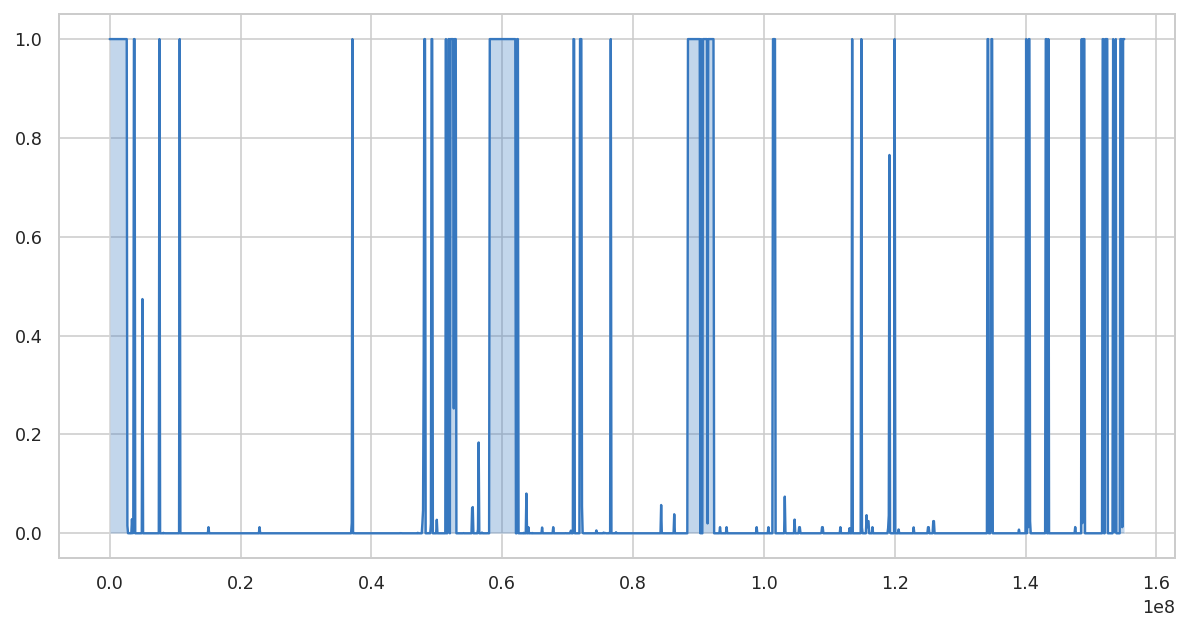

In [31]:
with sns.xkcd_palette(["windows blue", "amber", "greyish", "faded green", "dusty purple"]):
    fig, ax = plt.subplots(figsize=(10, 5))
    g = ax.plot(missing_windows.start, missing_windows.mean_prop_indivs_missing)
    g = ax.fill_between(missing_windows.start, missing_windows.mean_prop_indivs_missing, alpha=0.3)

In [32]:
tot_missing = (missing_windows
 .loc[sweep_data.swept==True, ['start', 'end']]
 .drop_duplicates()
 .assign(length=lambda df: df.end-df.start)
 .length.sum()
)
tot_missing

9100000

## How much of chromosome is covered by ECHs?

In [33]:
tot_covered = (sweep_data
 .loc[sweep_data.swept==True, ['start', 'end']]
 .drop_duplicates()
 .assign(length=lambda df: df.end-df.start)
 .length.sum()
)
tot_covered, tot_covered / 155270560, tot_covered / (155270560 - tot_missing)

(17300000, 0.11141841698774063, 0.1183548862370097)

## Consequtive regions with missing data

Run id for windows with missing/non-missing status:

In [34]:
def run_id(sr):
    return (sr != sr.shift()).cumsum()

missing_windows['missing_status_run_id'] = run_id(missing_windows.is_missing)

For each individual compute how big a run of non-missing windows that window is part of:

In [35]:
missing_windows['missing_status_run_length'] = (missing_windows
                                 .groupby(['missing_status_run_id'])['missing_status_run_id']
                                 .transform(numpy.size)
                                )
missing_windows.head()

,start,end,mean_prop_indivs_missing,is_missing,missing_status_run_id,missing_status_run_length
0,0,100000,1.0,True,1,27
1,100000,200000,1.0,True,1,27
2,200000,300000,1.0,True,1,27
3,300000,400000,1.0,True,1,27
4,400000,500000,1.0,True,1,27


Get start end coordinates of each region:

In [36]:
missing_regions = (missing_windows
                   .groupby(['missing_status_run_id', 'is_missing'])
                   .aggregate({'start': 'min', 'end': 'max'})
                   .reset_index()
                  )
missing_regions.head()

,missing_status_run_id,is_missing,start,end
0,1,True,0,2700000
1,2,False,2700000,3700000
2,3,True,3700000,3900000
3,4,False,3900000,5000000
4,5,True,5000000,5100000


In [37]:
missing_regions.to_hdf(results_dir / 'missing_regions.hdf', 'df', format='table', mode='w')

## Proportion of swept sequence in each non-African individual

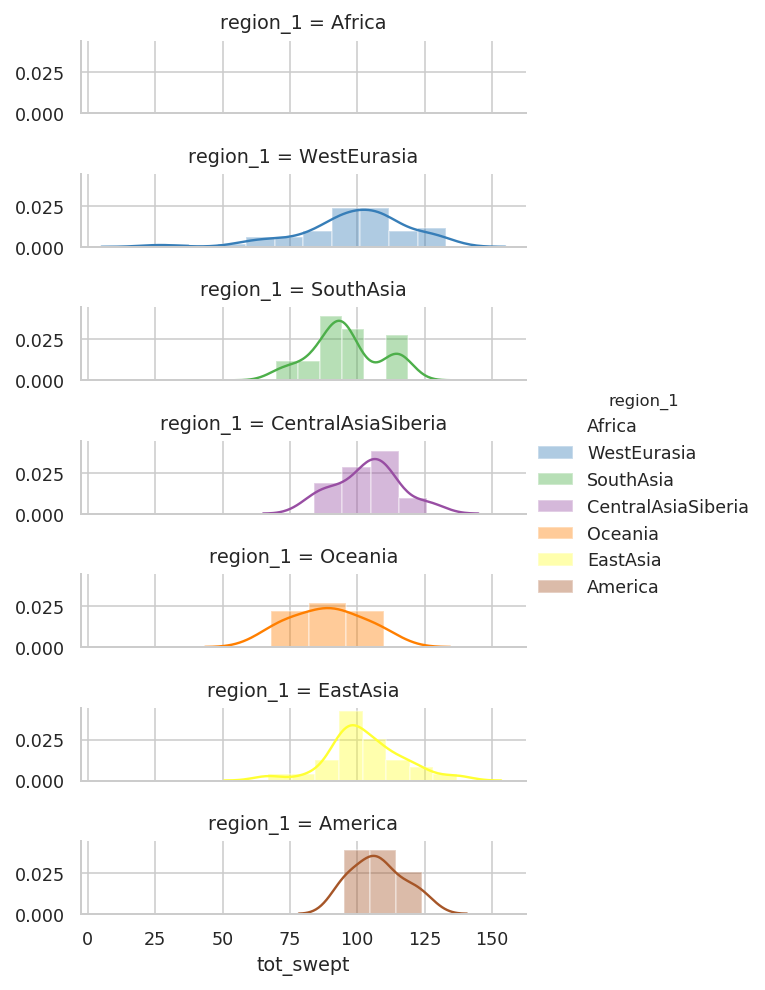

In [38]:
plot_df = (sweep_data
           .loc[lambda df: df.region_1 != 'Africa']
           .groupby(['indiv_1', 'region_1'])['swept']
           .agg('sum')
           .to_frame('tot_swept')
           .reset_index()
          )

with sns.color_palette('Set1'):
    g = sns.FacetGrid(plot_df, hue="region_1", row='region_1', legend_out=True, height=1, aspect=4)
    g = g.map(sns.distplot, "tot_swept")
    g.add_legend()

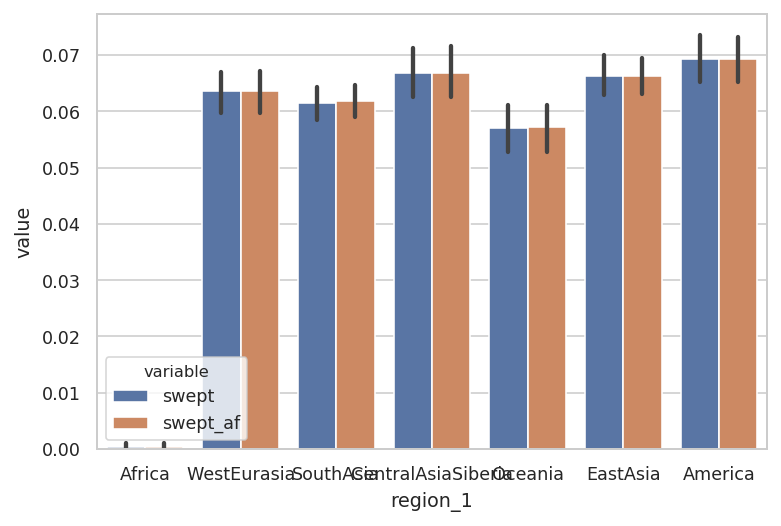

In [39]:
df = (sweep_data[['indiv_1', 'region_1', 'swept', 'swept_af']]
           .groupby(['indiv_1', 'region_1'])
           .mean()
           .reset_index()
           .loc[lambda df: (~numpy.isnan(df.swept))]
          )
plot_df = pandas.melt(df, id_vars=['indiv_1', 'region_1'], value_vars=['swept', 'swept_af'])

g = sns.barplot(data=plot_df, x='region_1', y='value', hue='variable', 
               order=sweep_data.region_1.cat.categories.values)

plt.savefig(str(figures_dir / 'prop_swept_by_region.pdf'))
plt.savefig(str(figures_dir / 'prop_swept_by_region.png'))

## Impact of missing data on sweep calling

To what extent is missing data responsible for what we call as swept.

It is possible that some regions of the chromsome are without sweeps simply because these regions have more missing data, so a run of sweep clade windows cannot be called. 

In [40]:
plot_df = (sweep_data[['start', 'end', 'swept']]
           .merge(missing_windows[['start', 'end', 'is_missing', 'missing_status_run_length']], 
                  on=['start', 'end'], how='left')
        )
plot_df.head()

,start,end,swept,is_missing,missing_status_run_length
0,0,100000,False,True,27
1,100000,200000,False,True,27
2,200000,300000,False,True,27
3,300000,400000,False,True,27
4,400000,500000,False,True,27


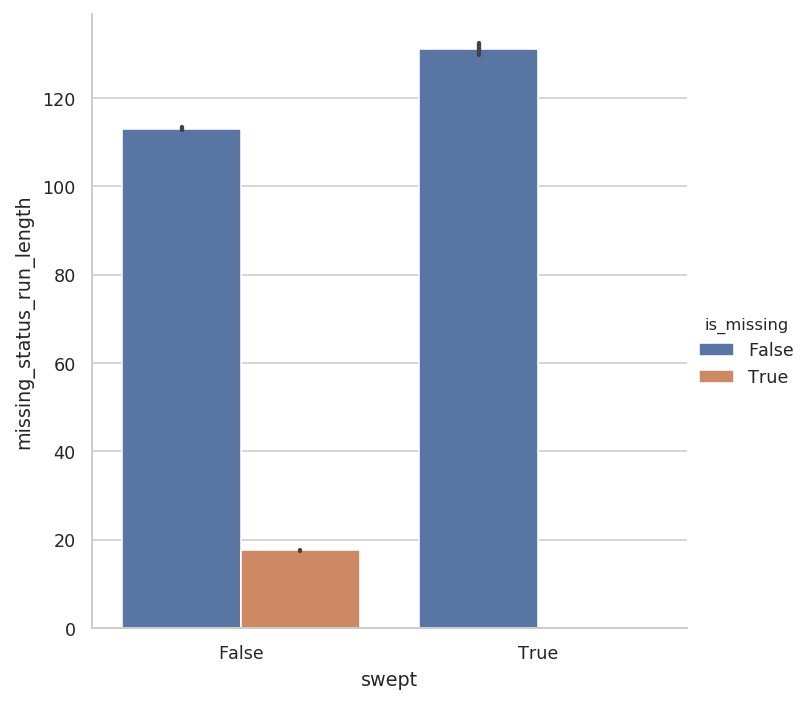

In [41]:
g = sns.catplot(x='swept', y='missing_status_run_length', hue='is_missing', kind='bar', data=plot_df)

Windows called as swept are part of longer consequeitvely called regions than windows not called as swept. 
That could simply be becuase we demand that swept regions are always at least 500kb.

A better way to address the impact of missing data on the distribuion of swept windows across the chromosome, would be to see if windows called as `sweep_clade` are more often in non-missing regions larger than 500kb:

In [42]:

plot_df = (sweep_data[['start', 'end', 'win_swept']]#'sweep_clade']]
           .merge(missing_windows[['start', 'end', 'is_missing', 'missing_status_run_length']], 
                  on=['start', 'end'], how='left')
#           .loc[lambda df: df.is_missing == False]
           .assign(above_length_thresh = lambda df: df.missing_status_run_length >= analysis_globals.min_run_length)
        )
plot_df.head()


,start,end,win_swept,is_missing,missing_status_run_length,above_length_thresh
0,0,100000,False,True,27,True
1,100000,200000,False,True,27,True
2,200000,300000,False,True,27,True
3,300000,400000,False,True,27,True
4,400000,500000,False,True,27,True


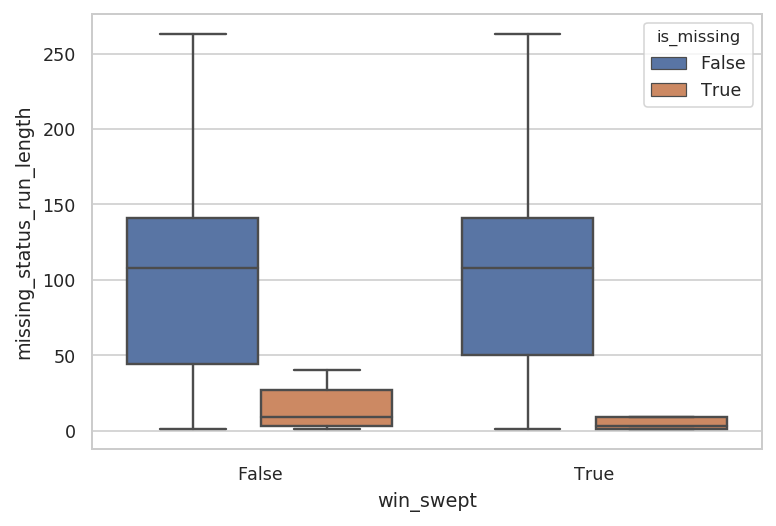

In [43]:
#sns.boxplot(x="sweep_clade", y="missing_status_run_length", hue='is_missing', data=plot_df)
sns.boxplot(x="win_swept", y="missing_status_run_length", hue='is_missing', data=plot_df) ;

It does seem that the run length of non-missing windows is not smaller for windows that are not in a sweep clade. In addition the mean length of non-missing regions is larger than 100, I.e. *much* larger than 5 (500kb)

## Make set that is not swept in any individual

In [44]:
#sweep_data = pandas.read_hdf(results_dir / 'sweep_data.hdf')

In [45]:
sweep_data['never_swept'] = sweep_data.groupby('start')['swept'].transform(lambda sr: sr.sum() == 0)
sweep_data['never_swept_af'] = sweep_data.groupby('start')['swept_af'].transform(lambda sr: sr.sum() == 0)
sweep_data['never_win_swept'] = sweep_data.groupby('start')['win_swept'].transform(lambda sr: sr.sum() == 0)
sweep_data['never_win_swept_af'] = sweep_data.groupby('start')['win_swept_af'].transform(lambda sr: sr.sum() == 0)

## Split distribution of distances into regions with no sweept and regions with at least some swept

In [46]:
df = (all_male_dist_twice
      .loc[(all_male_dist_twice.region_label_1 != 'Africa') & (all_male_dist_twice.region_label_2 != 'Africa'),
          ['start', 'indiv_1', 'indiv_2', 'dist']]
      .merge(sweep_data[['start', 'indiv_1', 'swept', 'never_swept']], on=['start', 'indiv_1'], how='left')
     )

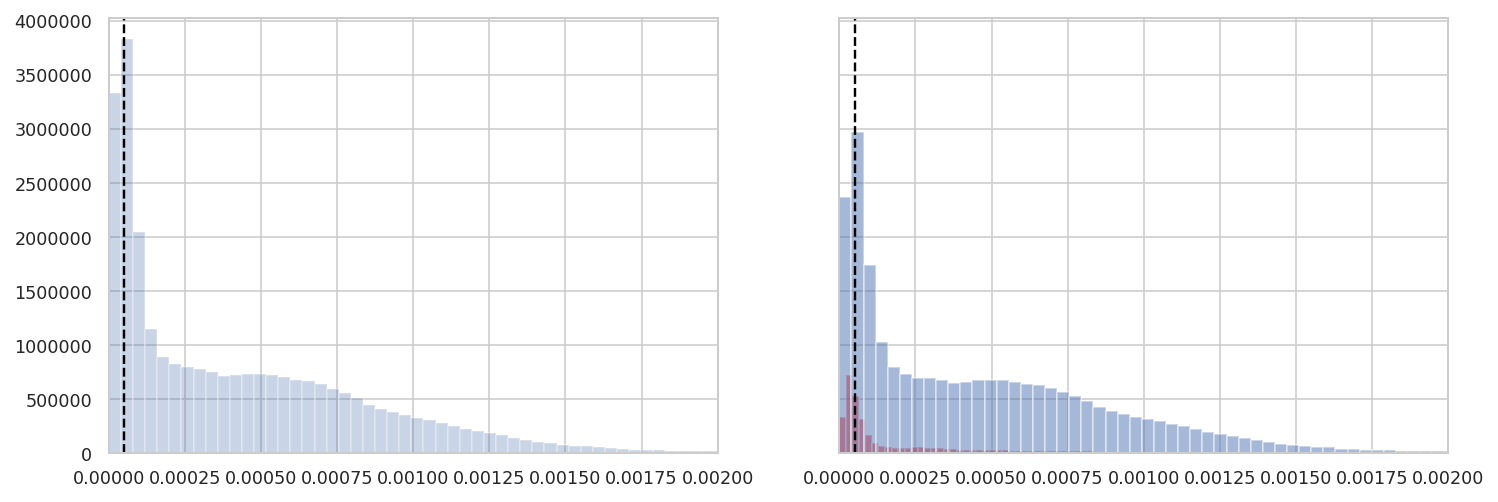

In [47]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4), sharex=True, sharey=True)

ax1.hist(df.dist.loc[~df.dist.isnull()], bins=100, alpha=0.3)

ax2.hist(df.dist.loc[~df.dist.isnull() & (df.never_swept == False)], bins=100, alpha=0.5, color='red')
ax2.hist(df.dist.loc[~df.dist.isnull() & (df.never_swept == True)], bins=100, alpha=0.5) ;

for ax in fig.axes:
    plt.sca(ax)
    plt.xlim(0, 0.002)
    plt.axvline(5e-5, color='black', linestyle='dashed')
#    plt.xticks(rotation=90)

## Make a set of conservatively swept and non-swept haplotypes

In [48]:
sweep_data['conserv_swept_group'] = [x and 'yes' or 'no' for x in sweep_data['swept']]
sweep_data['conserv_swept_group'].where(sweep_data['swept'] == sweep_data['win_swept'], 'ambig', inplace=True)
sweep_data['conserv_swept_group'].where(sweep_data.not_missing == True, 'ambig', inplace=True)

sweep_data['conserv_swept_group_af'] = [x and 'yes' or 'no' for x in sweep_data['swept_af']]
sweep_data['conserv_swept_group_af'].where(sweep_data['swept_af'] == sweep_data['win_swept_af'], 'ambig', inplace=True)
sweep_data['conserv_swept_group_af'].where(sweep_data.not_missing == True, 'ambig', inplace=True)

In [49]:
sweep_data.conserv_swept_group.value_counts()

no       178365
ambig     61748
yes       11311
Name: conserv_swept_group, dtype: int64

## Find all windows with both reliably swept and non-swept haplotypes

In [50]:
sweep_data['partial_sweep_win'] = sweep_data.groupby('start')['conserv_swept_group'].transform(lambda sr: (sr == 'yes').sum() > 0 and (sr == 'no').sum() > 0)
sweep_data['partial_sweep_win_af'] = sweep_data.groupby('start')['conserv_swept_group_af'].transform(lambda sr: (sr == 'yes').sum() > 0 and (sr == 'no').sum() > 0)

In [51]:
tmrca_stats = pandas.read_hdf(str(results_dir / 'pruned_tmrca_stats.hdf'))#.loc[lambda df: df.region == 'World']

In [52]:
plot_df = sweep_data.merge(tmrca_stats[['start', 'end', 'tmrca', 'tmrca_half', 'rel_tmrca_half']],
                           on=['start', 'end'],
                           how='left')

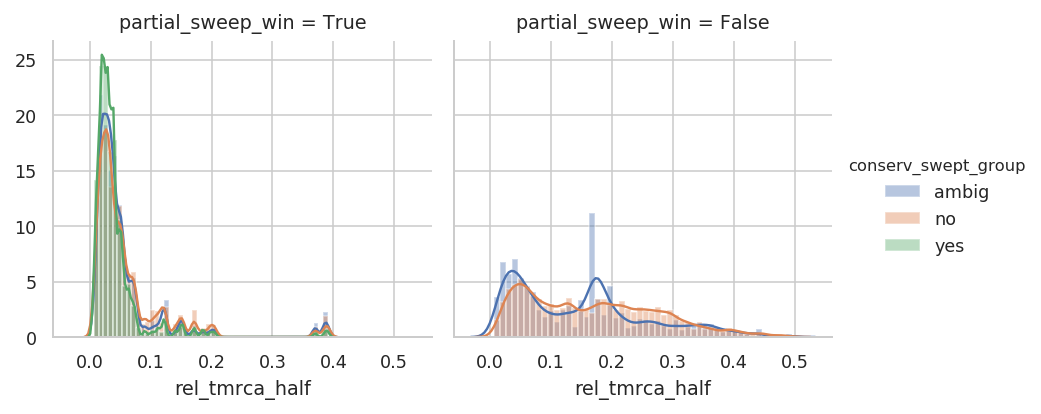

In [53]:
g = sns.FacetGrid(plot_df, col="partial_sweep_win",  hue="conserv_swept_group", col_order=[True, False])
g = g.map(sns.distplot, "rel_tmrca_half")
g = g.add_legend()

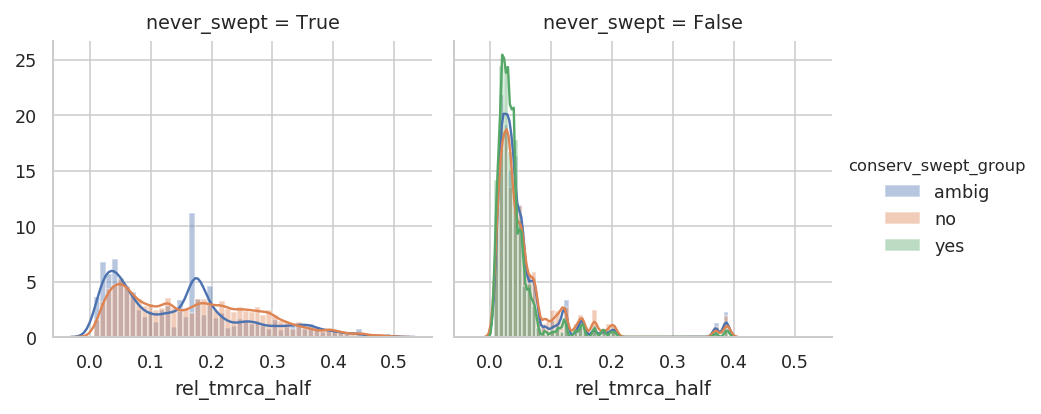

In [54]:
g = sns.FacetGrid(plot_df, col="never_swept",  hue="conserv_swept_group", col_order=[True, False])
g = g.map(sns.distplot, "rel_tmrca_half")
g = g.add_legend()

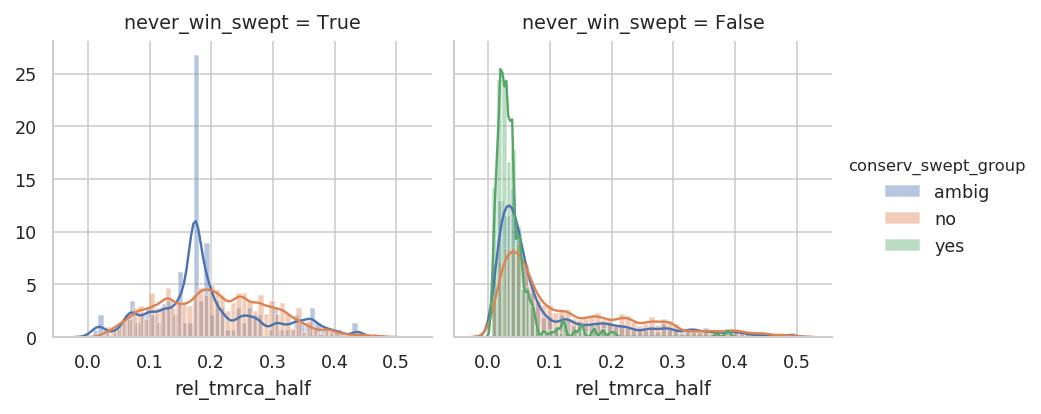

In [55]:
g = sns.FacetGrid(plot_df, col="never_win_swept",  hue="conserv_swept_group", col_order=[True, False])
g = g.map(sns.distplot, "rel_tmrca_half")
g = g.add_legend()

## Proportion of missing windows among swept and never swept

Missing among swept:

In [56]:
numpy.bitwise_and(sweep_data.swept, ~sweep_data.not_missing).sum() / sweep_data.swept.sum()

0.00014484356894553882

Missing among never swept:

In [57]:
numpy.bitwise_and(sweep_data.never_swept, ~sweep_data.not_missing).sum() / sweep_data.never_swept.sum()

0.12501454802639236

## Save sweep data

In [58]:
#del sweep_data['swept_conservative']

In [59]:
sweep_data.to_hdf(results_dir / 'sweep_data.hdf', 'df', format="table", mode='w')
#sweep_data_1Mb.to_hdf(results_dir / 'sweep_data_1Mb.hdf', 'df', format="table", mode='w')

## Start end coordinates of each swept haplotype

In [60]:
#sweep_data = pandas.read_hdf(results_dir / 'sweep_data.hdf')

In [61]:
# now you can easily get the intervals for each swept haplotype
sweep_coord = (sweep_data
               .loc[sweep_data.swept == True]
               .groupby(['indiv_1', 'run_id'])
               .aggregate({'start': 'min', 'end': 'max', 'mean_dist': 'mean', 
                           'region_label_1': ident_scalar, 'pop_1': ident_scalar})
               .reset_index(level=['indiv_1', 'run_id'])
              )
sweep_coord.to_hdf(results_dir / 'sweep_coord.hdf', 'df', format='table', mode='w')

sweep_coord_af = (sweep_data
               .loc[sweep_data.swept_af == True]
               .groupby(['indiv_1', 'run_id'])
               .aggregate({'start': 'min', 'end': 'max', 'mean_dist': 'mean', 
                           'region_label_1': ident_scalar, 'pop_1': ident_scalar})
               .reset_index(level=['indiv_1', 'run_id'])
              )
sweep_coord_af.to_hdf(results_dir / 'sweep_coord_af.hdf', 'df', format='table', mode='w')

All individuals sorted by region, population, individual name and population latitiude:

## Map of all swept haplotypes

In [62]:
pop_locations = pickle.load(open(str(results_dir / 'pop_locations.pkl'), 'rb'))

# pop_1_long, pop_1_lat = zip(*[pop_locations[x] for x in all_male_indiv_dist.pop_1])

# all_indivduals = (all_male_indiv_dist
#                   .assign(pop_1_long=pop_1_long, pop_1_lat=pop_1_lat)
#                   .sort_values(by=['region_1', 'pop_1', 'indiv_1', 'pop_1_lat'])
#                   .loc[:, ['region_1', 'pop_1', 'indiv_1']]
#                   .drop_duplicates()                    
#                    )['indiv_1']

pop_1_long, pop_1_lat = zip(*[pop_locations[x] for x in sweep_data.pop_1])

all_indivduals = (sweep_data
                  .assign(pop_1_long=pop_1_long, pop_1_lat=pop_1_lat)
                  .sort_values(by=['region_1', 'pop_1', 'indiv_1', 'pop_1_lat'])
                  .loc[:, ['region_1', 'pop_1', 'indiv_1']]
                  .drop_duplicates()                    
                   )['indiv_1']

all_indivduals.size

162

Draw swept regions for each haplotypes:

In [63]:

admix_1Mb_windows_chrX = pandas.read_hdf(results_dir / 'admix_1Mb_windows_chrX.hdf')
# global admix proportion
admix_df = (admix_1Mb_windows_chrX
                              .groupby(['chrom', 'start'])
                              .aggregate(numpy.mean)
                              .reset_index()
                             )
refseq_density = pandas.read_hdf(results_dir / 'refseq_density.hdf')

human_chimp_low_ils_regions_chrX = pandas.read_hdf(results_dir / 'human_chimp_low_ils_regions_chrX.hdf')
human_orang_low_ils_regions_chrX = pandas.read_hdf(results_dir / 'human_chimp_low_ils_regions_chrX.hdf')

ampliconic_regions = pandas.read_hdf(results_dir / 'ampliconic_regions.hdf')

low_ape_pi_regions = pandas.read_hdf(results_dir / 'low_ape_pi_regions.hdf')
sp = tuple(x in ['EC', 'WLG', 'SO'] for x in low_ape_pi_regions.species)
ape_regions = low_ape_pi_regions.loc[lambda df: (df.chrom == 'X') & sp]

no_neanderthal_eur = pandas.read_hdf(results_dir / 'no_neanderthal_eur.hdf')
no_neanderthal_asn = pandas.read_hdf(results_dir / 'no_neanderthal_asn.hdf')

Shriram no European neanderthal admixture top line (orange)
Shriram no Asian neanderthal admixture top line (orange)
NB: Admix proportion is truncated (black) at 10%
Low ILS regions in pink


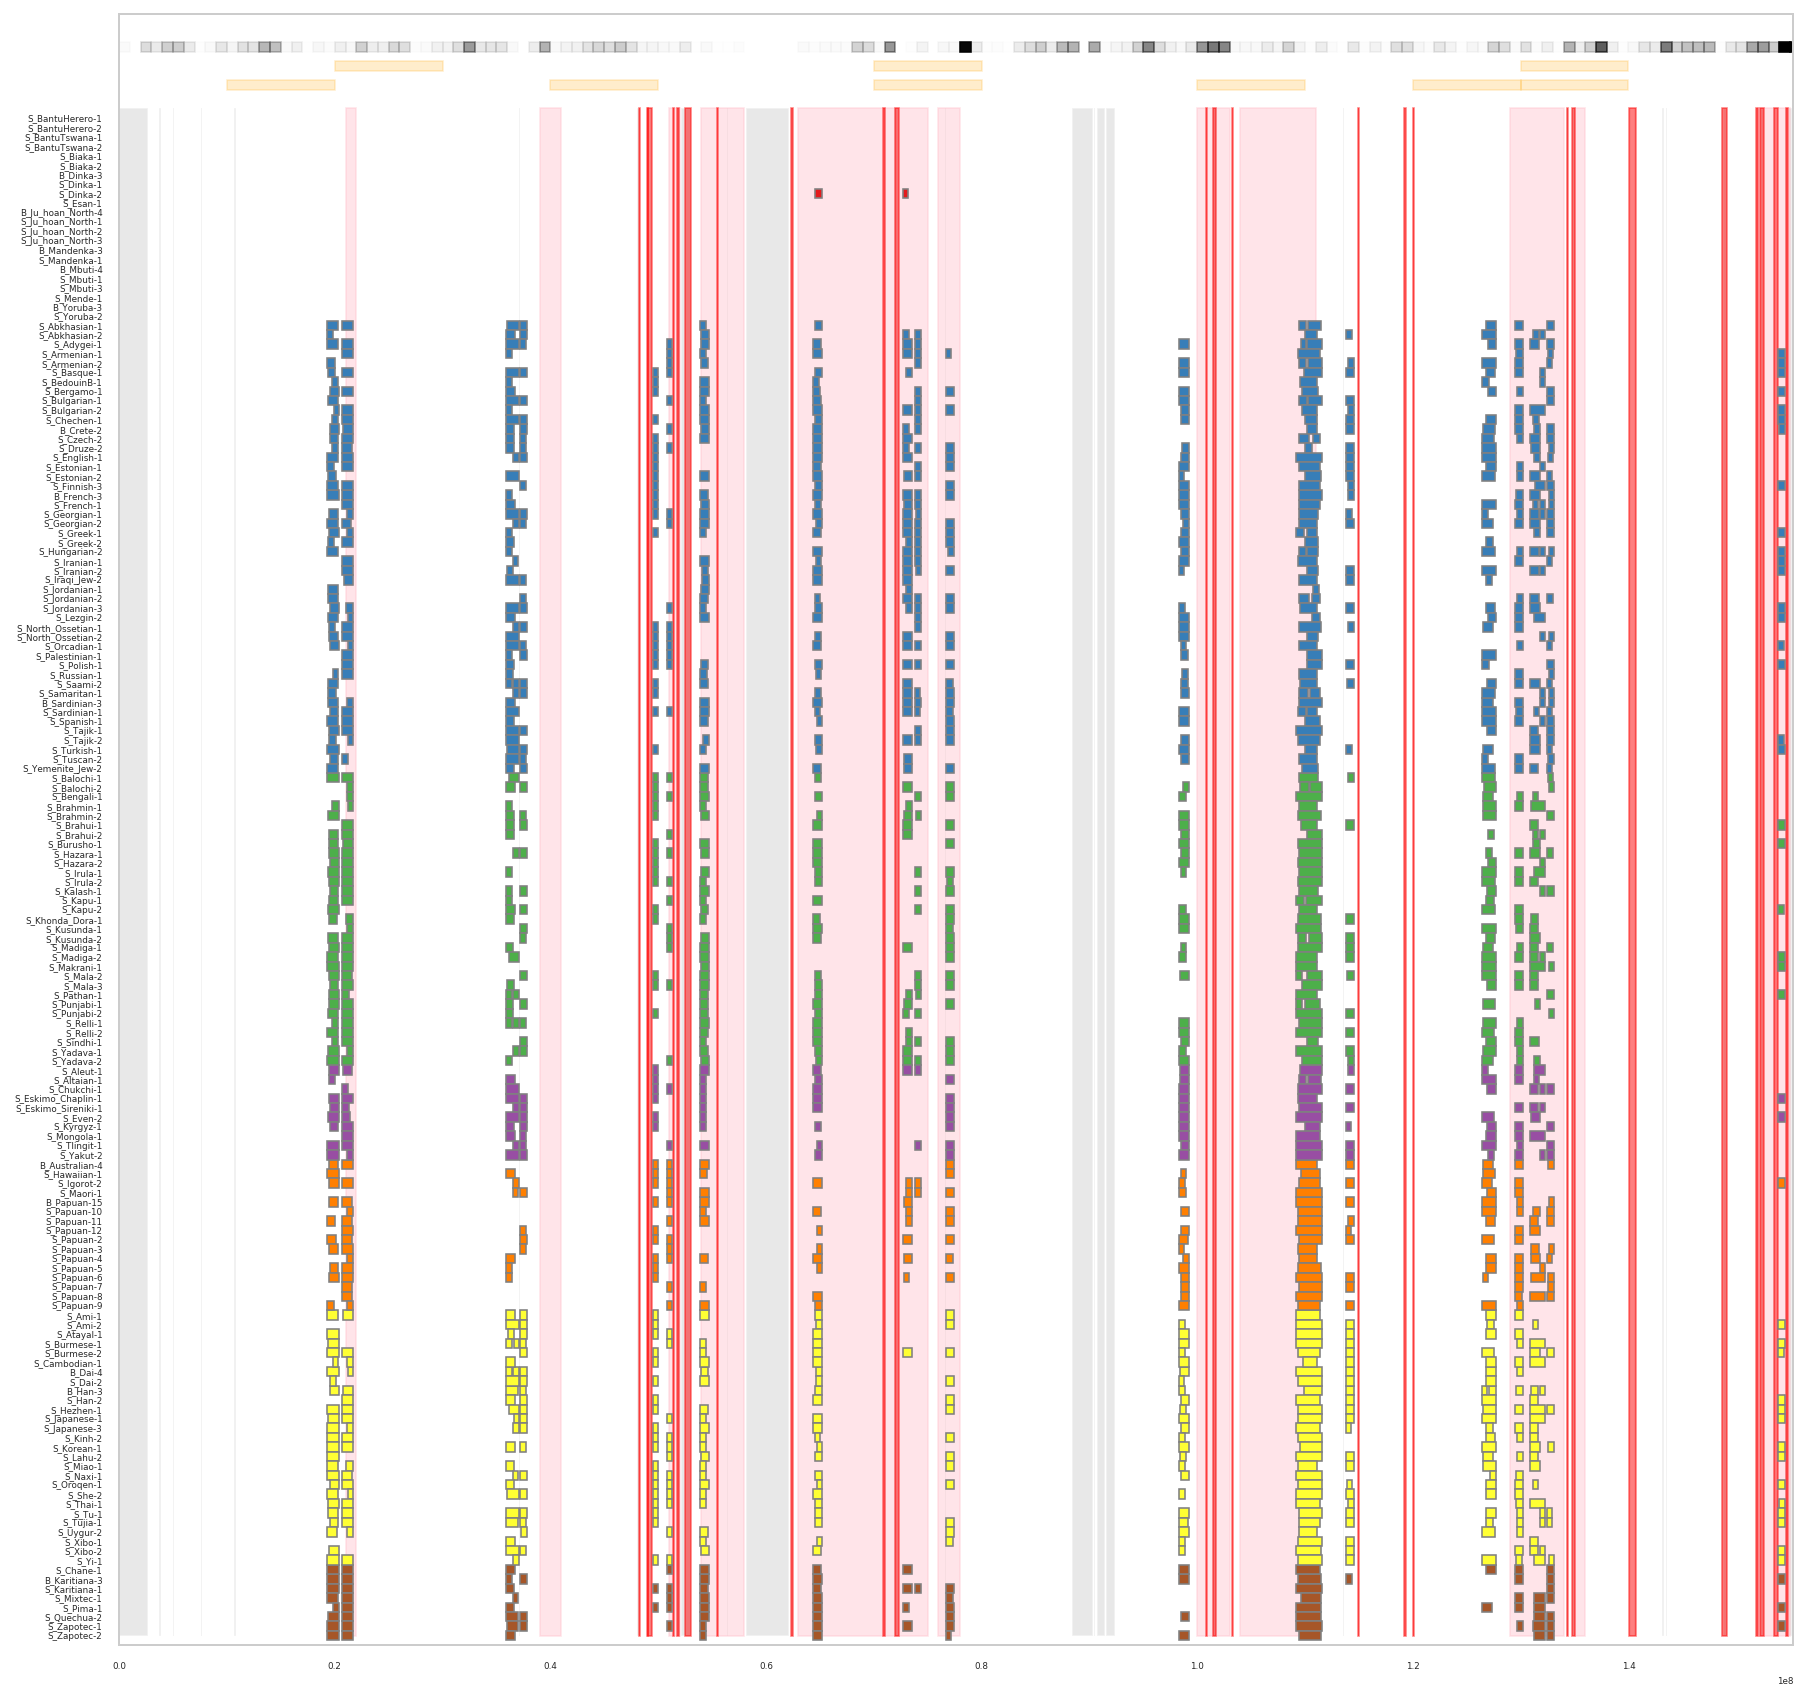

In [64]:
# turn indiv_1 into category with levels including any with no sweeps, and a corresponding int
plot_df = (sweep_coord
           .assign(indiv_1 = pandas.Categorical(sweep_coord.indiv_1,
                                                   categories=all_indivduals.tolist(),
                                                   ordered=True))
           .assign(indiv_code = lambda df: df.indiv_1.cat.codes)
          )

with sns.plotting_context('paper', font_scale=0.5):
    with sns.axes_style("whitegrid", {'axes.grid' : False}):
        fig, ax = plt.subplots(figsize=(15,15))
        ax.set_xlim([0, chromosome_lengths['X']])
#         ax.set_ylim([0, len(all_indivduals)])
        ax.set_ylim([-1, len(all_indivduals)+10])
    
        plt.yticks(range(len(all_indivduals)), reversed(all_indivduals.tolist()))

        print('Shriram no European neanderthal admixture top line (orange)')
        for segm in no_neanderthal_eur.loc[lambda df: df.chrom == 'X'].itertuples():
            g = ax.add_patch(Rectangle((segm.start, len(all_indivduals)+2), segm.end-segm.start, 1, 
                                          facecolor='orange', edgecolor='orange', alpha=0.2, zorder=0))
    
        print('Shriram no Asian neanderthal admixture top line (orange)')
        for segm in no_neanderthal_asn.loc[lambda df: df.chrom == 'X'].itertuples():
            g = ax.add_patch(Rectangle((segm.start, len(all_indivduals)+4), segm.end-segm.start, 1, 
                                          facecolor='orange', edgecolor='orange', alpha=0.2, zorder=0))
            
        print('NB: Admix proportion is truncated (black) at 10%')
        # top line
        for segm in admix_df.itertuples():
            alpha = min(segm.admix_prop*10, 1)
            g = ax.add_patch(Rectangle((segm.start, len(all_indivduals)+6), segm.end-segm.start, 1, 
                                          facecolor='black', edgecolor='black', alpha=alpha, zorder=0))
#         # background
#         for segm in admix_df.itertuples():
#             alpha = min(segm.admix_prop*10, 1)
#             g = ax.add_patch(Rectangle((segm.start, 0), segm.end-segm.start, len(all_indivduals), 
#                                           facecolor='black', edgecolor='black', alpha=alpha, zorder=0))
     
#         # exon density top line
#         print('NB: Refseq exon density is truncated (black) at 10%')
#         for segm in refseq_density.loc[lambda df: df.chrom == 'X'].itertuples():
#             alpha = min(segm.exon_density*10, 1)
#             g = ax.add_patch(Rectangle((segm.start, len(all_indivduals)+8), segm.end-segm.start, 1, 
#                                           facecolor='red', edgecolor='red', alpha=alpha, zorder=0))

#         # regional admixture proportion
#         for segm in region_admix_prop_with_pops.itertuples():
#             y = pop_categories.size - segm.pop_code - 1
#             g = ax.add_patch(Rectangle((segm.start, y), segm.end-segm.start, 1, 
#                                           facecolor='black', edgecolor='black', alpha=segm.admix_prop*10, zorder=0))
    
        for segm in plot_df.itertuples():            
            y = len(all_indivduals) - segm.indiv_code - 1
            g = ax.add_patch(Rectangle((segm.start, y-0.5), segm.end-segm.start, 1, 
                                        facecolor=region_colors[segm.region_label_1], edgecolor='grey'))

        for segm in missing_regions.loc[missing_regions.is_missing == True].itertuples():
            g = ax.add_patch(Rectangle((segm.start, 0), segm.end-segm.start, len(all_indivduals), 
                     facecolor='lightgray', 
                     edgecolor=None,
                     alpha=0.5,
                     zorder=0))
            
        print('Low ILS regions in pink')
        # human chimp low ils:
        for segm in human_chimp_low_ils_regions_chrX.itertuples():
            g = ax.add_patch(Rectangle((segm.start, 0), segm.end-segm.start, len(all_indivduals), 
                                          facecolor='pink', edgecolor='pink', alpha=0.3, zorder=0))
        # human orang low ils:        
        for segm in human_orang_low_ils_regions_chrX.itertuples():
            g = ax.add_patch(Rectangle((segm.start, 0), segm.end-segm.start, len(all_indivduals), 
                                          facecolor='pink', edgecolor='pink', alpha=0.15, zorder=0))

        for segm in ampliconic_regions.loc[lambda df: df.chrom == 'X'].itertuples():
            g = ax.add_patch(Rectangle((segm.start, 0), segm.end-segm.start, len(all_indivduals), 
                                          facecolor='red', edgecolor='red', alpha=0.5, zorder=0))

#         print('Great ape low pi regions in green')        
#         for segm in ape_regions.itertuples():
#             g = ax.add_patch(Rectangle((segm.start, 0), segm.end-segm.start, len(all_indivduals), 
#                                           facecolor='green', edgecolor='green', alpha=0.2, zorder=0))
                        

        plt.savefig(str(figures_dir / "swept_male_haplotypes_map_chrX.pdf"))

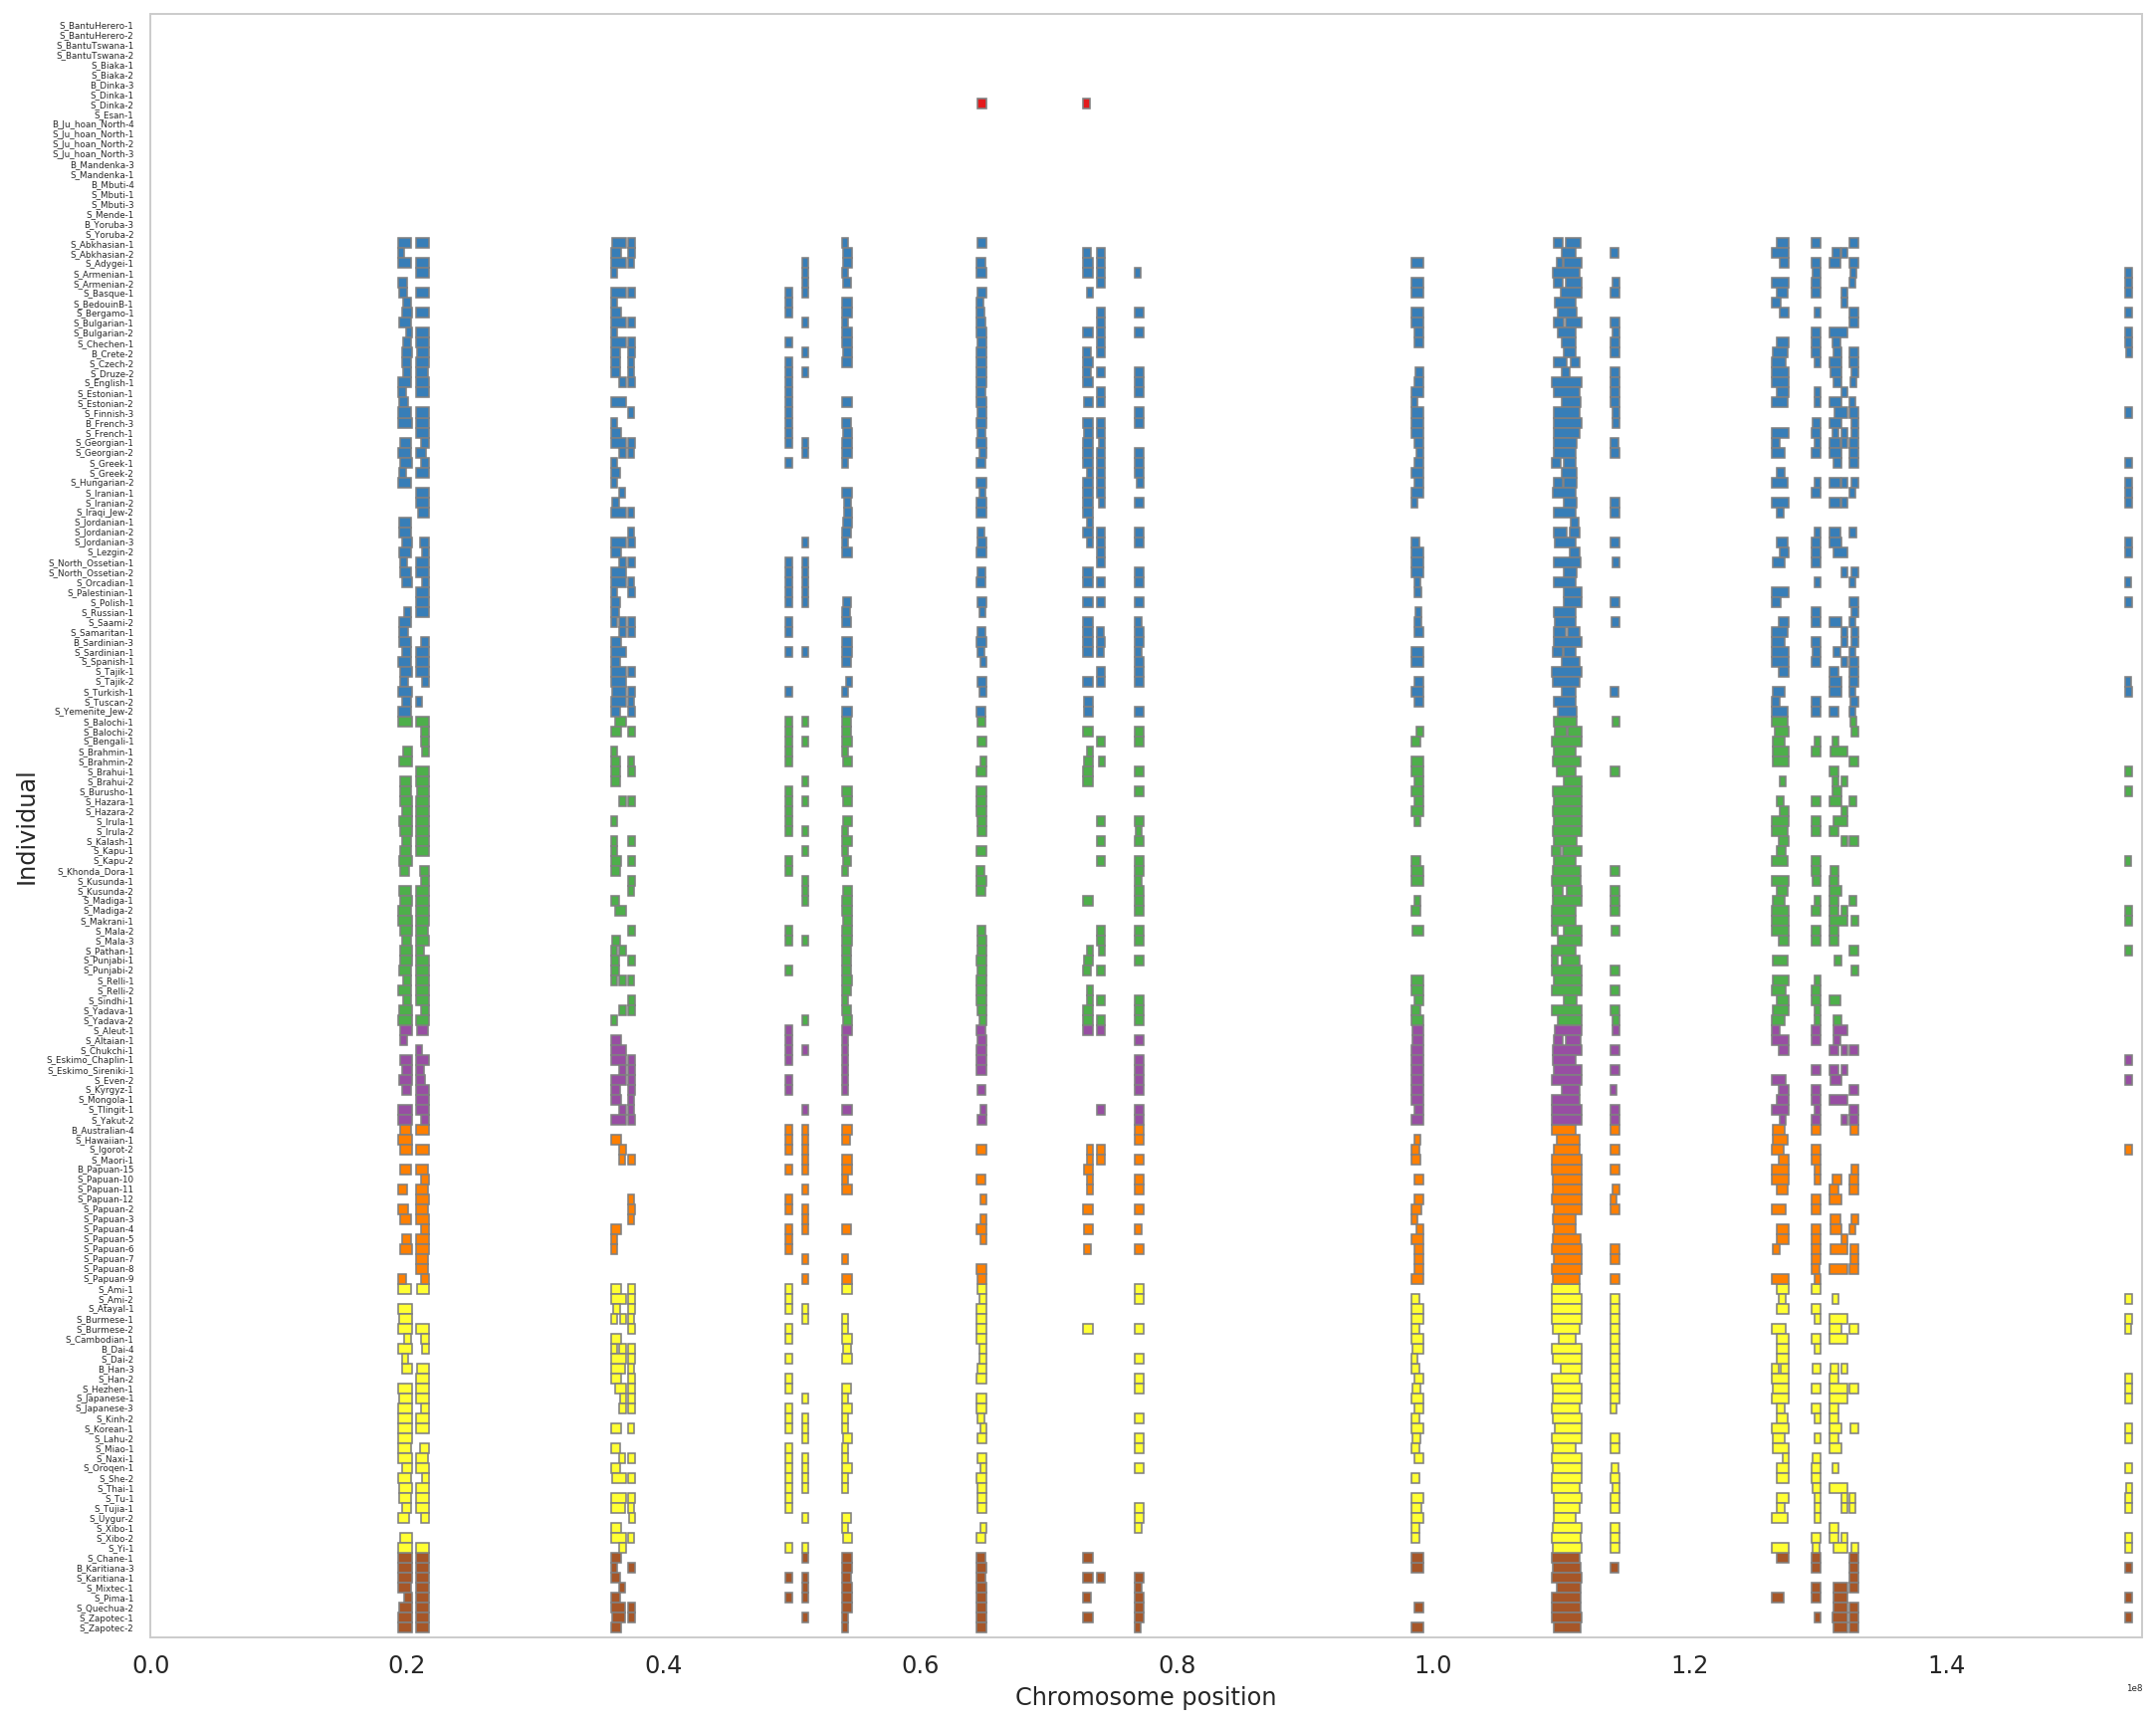

In [65]:
# turn indiv_1 into category with levels including any with no sweeps, and a corresponding int
plot_df = (sweep_coord
           .assign(indiv_1 = pandas.Categorical(sweep_coord.indiv_1,
                                                   categories=all_indivduals.tolist(),
                                                   ordered=True))
           .assign(indiv_code = lambda df: df.indiv_1.cat.codes)
          )

with sns.plotting_context('paper', font_scale=0.5):
    with sns.axes_style("whitegrid", {'axes.grid' : False}):
        fig, ax = plt.subplots(figsize=(15,12))
        ax.set_xlim([0, chromosome_lengths['X']])
        ax.set_ylim([-1, len(all_indivduals)])
        labs = pandas.Categorical(all_indivduals,
                           categories=all_indivduals,
                           ordered=True)
        
        plt.yticks(range(len(all_indivduals)), reversed(all_indivduals.tolist()))

        for segm in plot_df.itertuples():            
            y = len(all_indivduals) - segm.indiv_code - 1
            g = ax.add_patch(Rectangle((segm.start, y-0.5), segm.end-segm.start, 1, 
                                        facecolor=region_colors[segm.region_label_1], edgecolor='grey'))

#         for segm in missing_regions.loc[missing_regions.is_missing == True].itertuples():
#             g = ax.add_patch(Rectangle((segm.start, 0), segm.end-segm.start, len(all_indivduals), 
#                      facecolor='lightgray', 
#                      edgecolor=None,
#                      alpha=0.5,
#                      zorder=0))

        for tick in ax.xaxis.get_major_ticks():
            tick.label.set_fontsize(12) 
            
        plt.xlabel('Chromosome position', fontsize=12)
        plt.ylabel('Individual', fontsize=12)

        plt.tight_layout()
        
        plt.savefig(str(figures_dir / "swept_male_haplotypes_map_chrX_clean.pdf"))

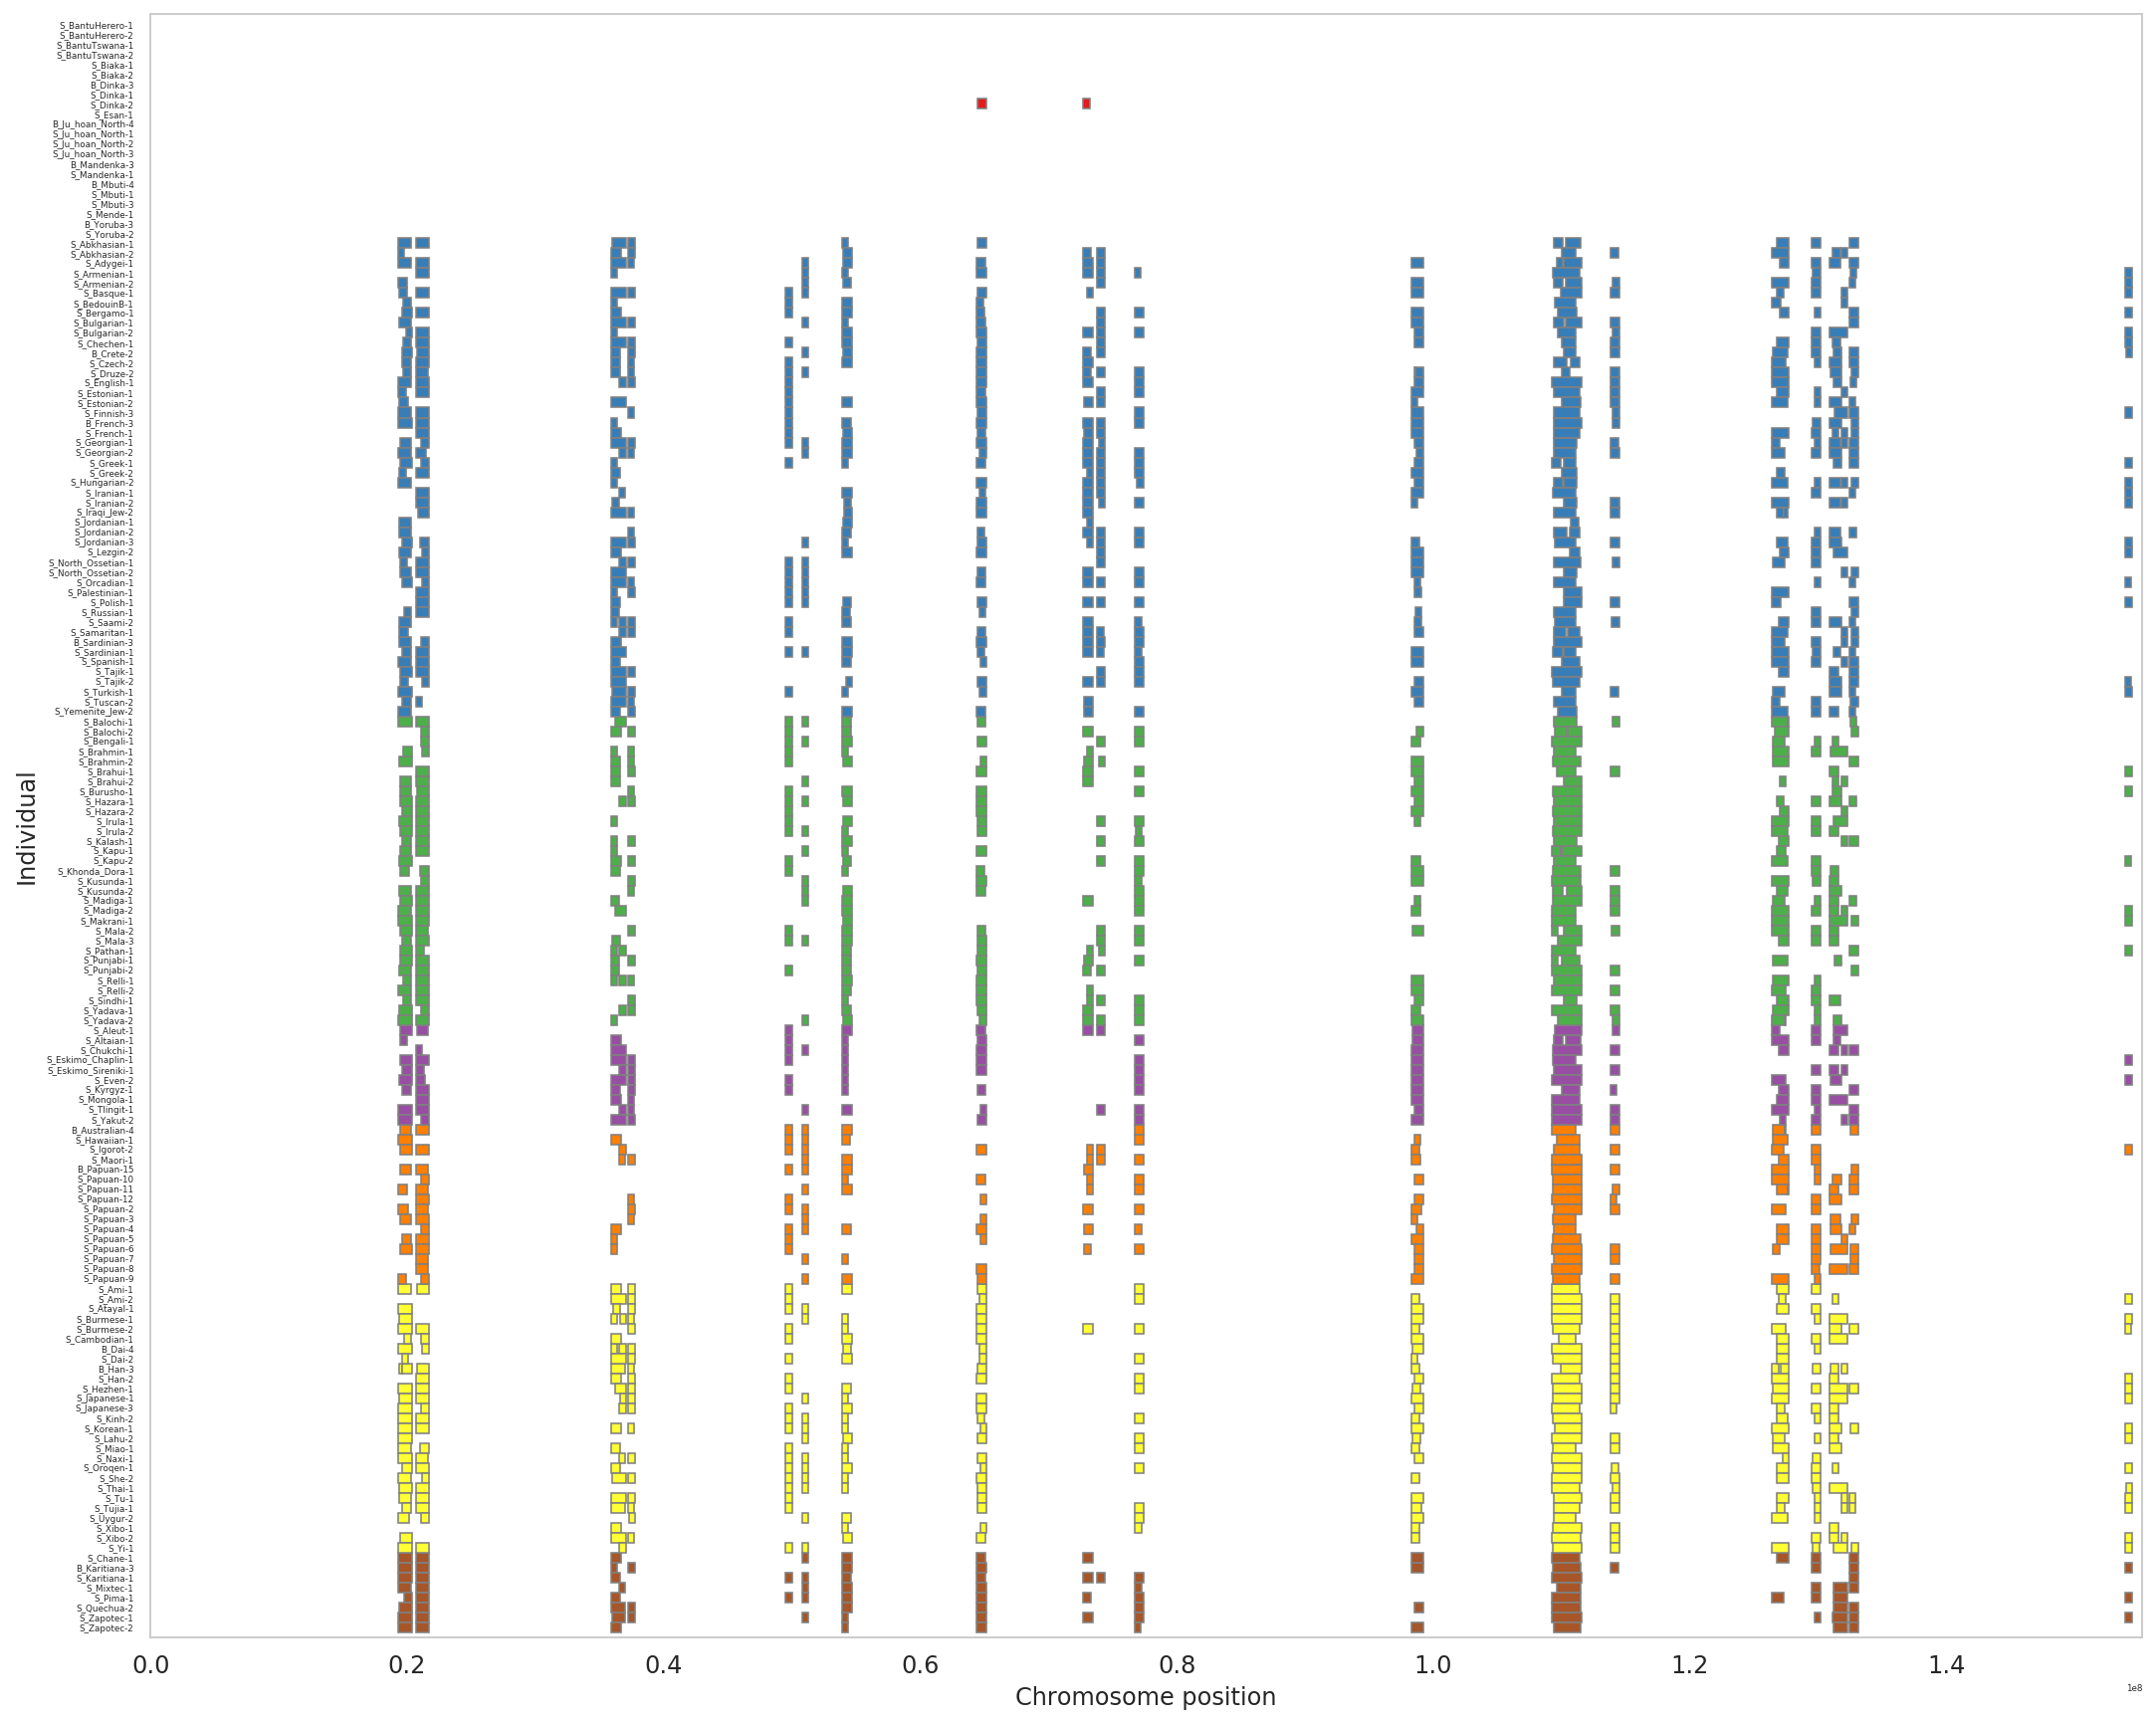

In [66]:
# turn indiv_1 into category with levels including any with no sweeps, and a corresponding int
plot_df = (sweep_coord_af
           .assign(indiv_1 = pandas.Categorical(sweep_coord_af.indiv_1,
                                                   categories=all_indivduals.tolist(),
                                                   ordered=True))
           .assign(indiv_code = lambda df: df.indiv_1.cat.codes)
          )

with sns.plotting_context('paper', font_scale=0.5):
    with sns.axes_style("whitegrid", {'axes.grid' : False}):
        fig, ax = plt.subplots(figsize=(15,12))
        ax.set_xlim([0, chromosome_lengths['X']])
        ax.set_ylim([-1, len(all_indivduals)])
        labs = pandas.Categorical(all_indivduals,
                           categories=all_indivduals,
                           ordered=True)
        
        plt.yticks(range(len(all_indivduals)), reversed(all_indivduals.tolist()))

        for segm in plot_df.itertuples():            
            y = len(all_indivduals) - segm.indiv_code - 1
            g = ax.add_patch(Rectangle((segm.start, y-0.5), segm.end-segm.start, 1, 
                                        facecolor=region_colors[segm.region_label_1], edgecolor='grey'))

#         for segm in missing_regions.loc[missing_regions.is_missing == True].itertuples():
#             g = ax.add_patch(Rectangle((segm.start, 0), segm.end-segm.start, len(all_indivduals), 
#                      facecolor='lightgray', 
#                      edgecolor=None,
#                      alpha=0.5,
#                      zorder=0))

        for tick in ax.xaxis.get_major_ticks():
            tick.label.set_fontsize(12) 
            
        plt.xlabel('Chromosome position', fontsize=12)
        plt.ylabel('Individual', fontsize=12)
        
        plt.tight_layout()
        
        plt.savefig(str(figures_dir / "swept_male_haplotypes_map_chrX_clean_af.pdf"))

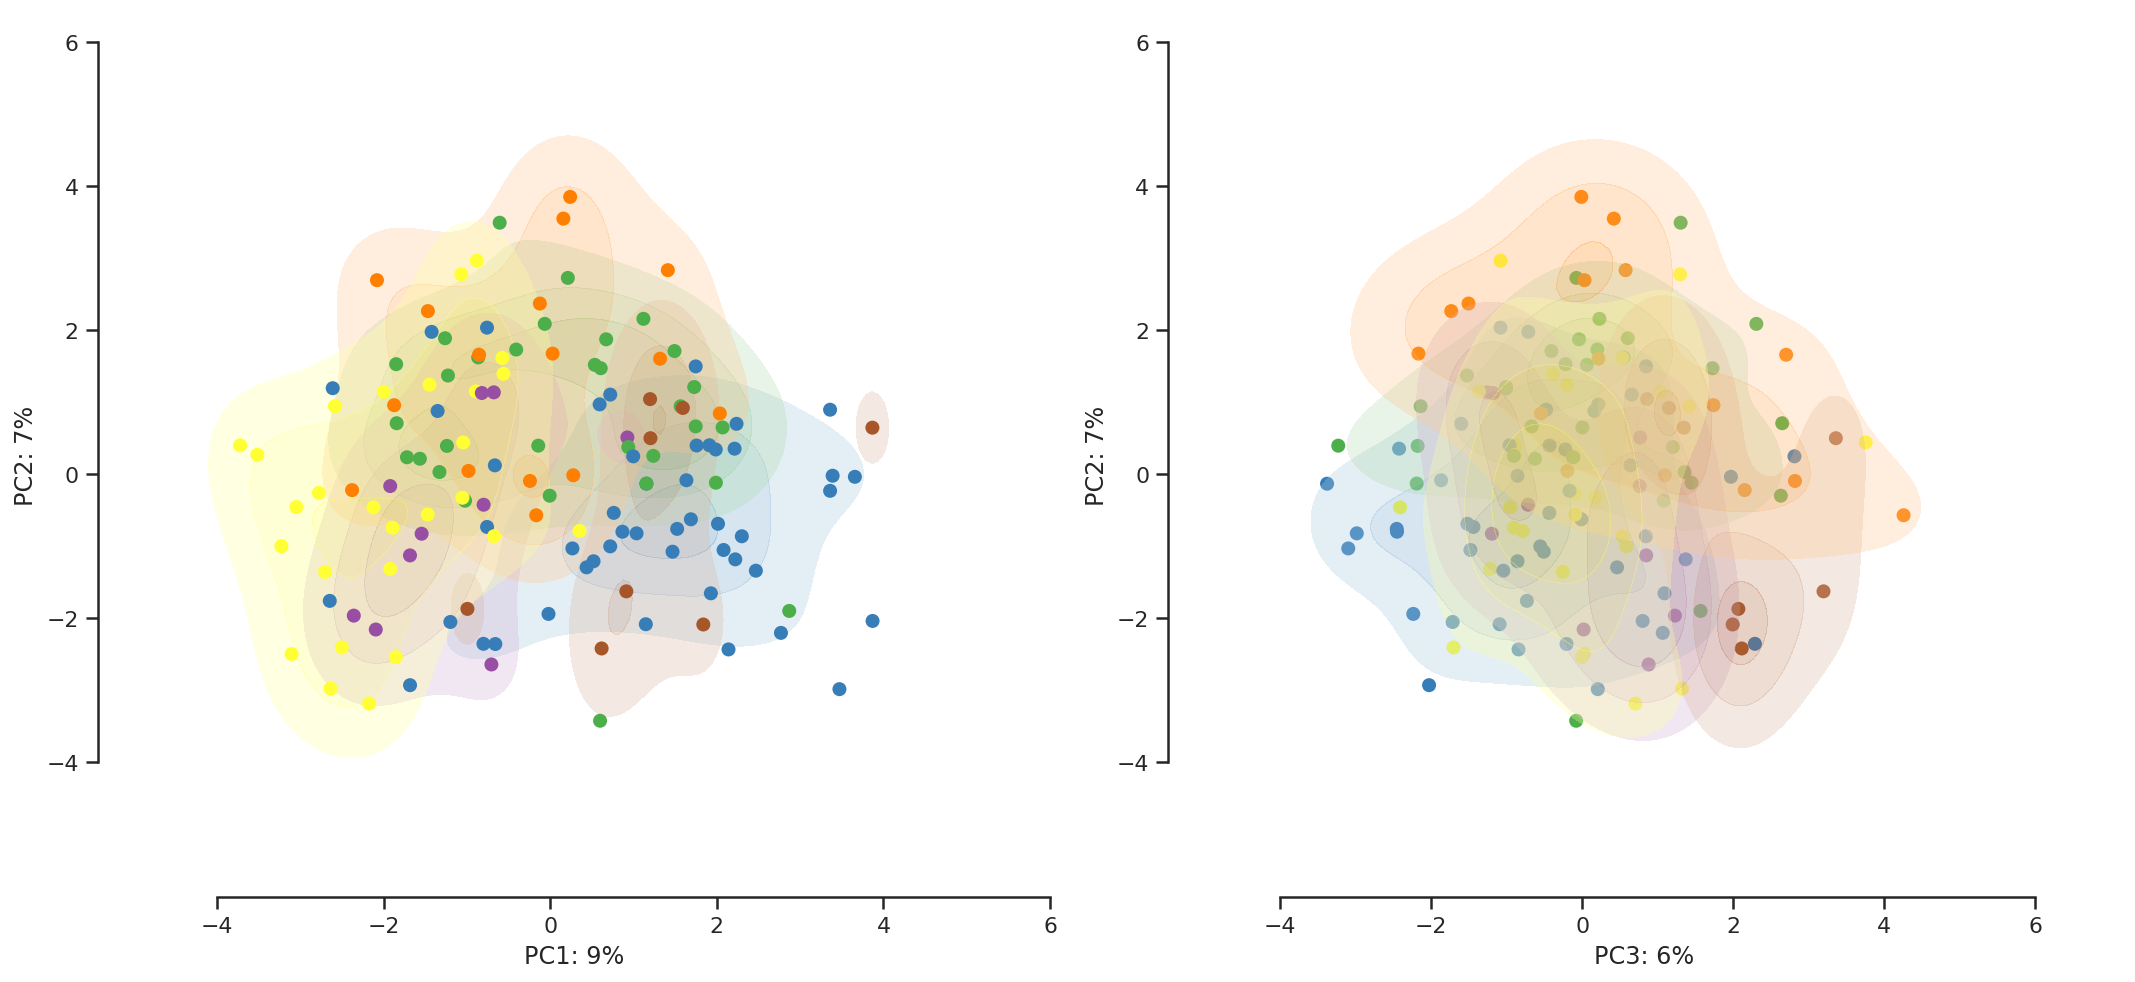

In [67]:
df = (sweep_data.loc[lambda df: df.region_1 != 'Africa', ['indiv_1', 'start', 'swept']]
       .pivot(index='indiv_1', columns='start', values='swept')
      )
colors = [region_colors[individuals[x]['Region']] for x in df.index.values]
mat = df.as_matrix().astype('int')

from sklearn.decomposition import PCA
pca = PCA(n_components=3)
pca.fit(mat)
labels = ["PC{}: {}%".format(i+1, int(round(r*100)), 0) for (i, r) in enumerate(pca.explained_variance_ratio_)]

X = pca.transform(mat)
with sns.plotting_context('notebook'):
    with sns.axes_style("ticks"):
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 7))
        for col, group in DataFrame(dict(x=X[:, 0], y=X[:, 1], color=colors)).groupby('color'):
            sns.kdeplot(group.x, group.y, ax=ax1, n_levels=3, cmap=None, color=col, alpha=0.3, shade=True, shade_lowest=False)
        ax1.scatter(X[:, 0], X[:, 1], c=colors)
        ax1.set_xlabel(labels[0])
        ax1.set_ylabel(labels[1])
        sns.despine(trim=True, ax=ax1)

        ax2.scatter(X[:, 2], X[:, 1], c=colors)
        for col, group in DataFrame(dict(x=X[:, 2], y=X[:, 1], color=colors)).groupby('color'):
            sns.kdeplot(group.x, group.y, ax=ax2, n_levels=3, cmap=None, color=col, alpha=0.3, shade=True, shade_lowest=False)
        ax2.set_xlabel(labels[2])
        ax2.set_ylabel(labels[1])
        sns.despine(trim=True, ax=ax2)

        plt.tight_layout()

        plt.savefig(str(figures_dir / 'pca_sweep.pdf'))

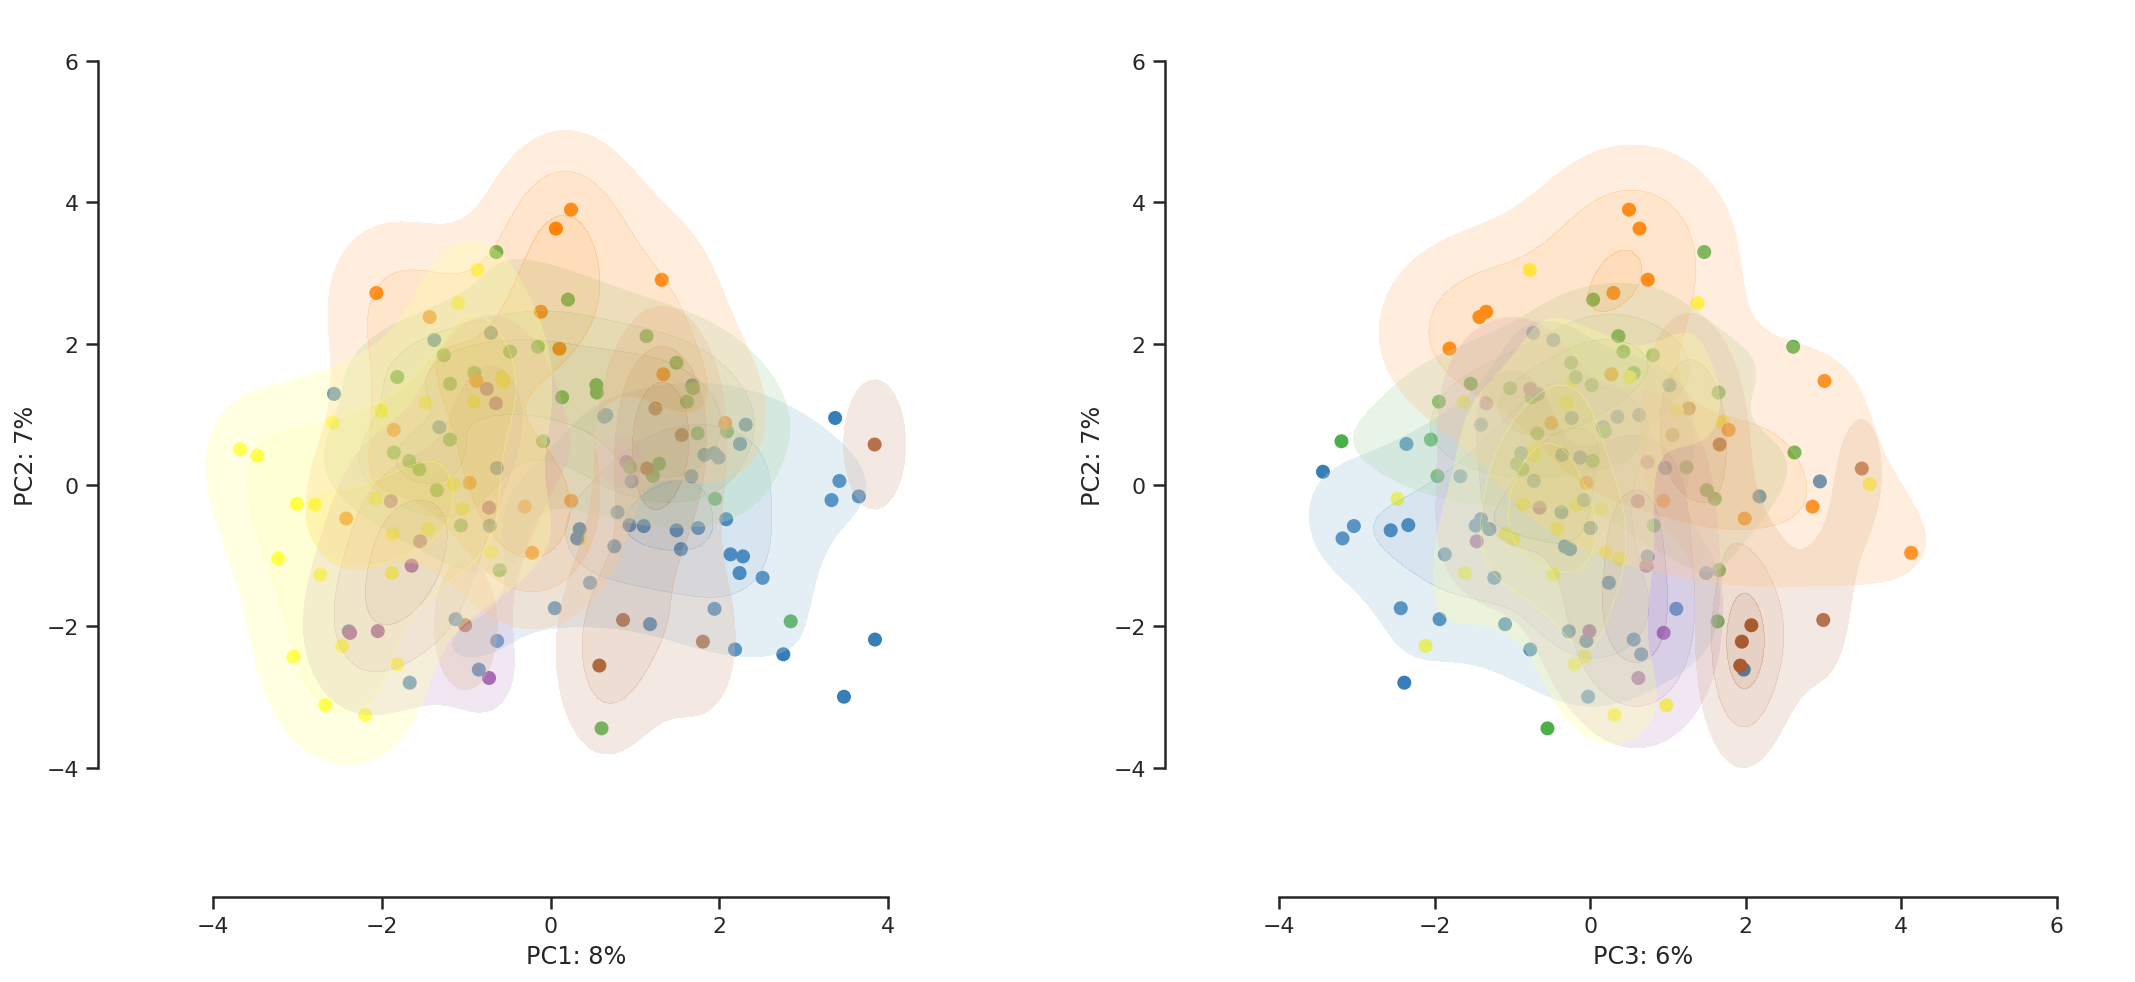

In [68]:
df = (sweep_data.loc[lambda df: df.region_1 != 'Africa', ['indiv_1', 'start', 'swept_af']]
       .pivot(index='indiv_1', columns='start', values='swept_af')
      )
colors = [region_colors[individuals[x]['Region']] for x in df.index.values]
mat = df.as_matrix().astype('int')

from sklearn.decomposition import PCA
pca = PCA(n_components=3)
pca.fit(mat)
labels = ["PC{}: {}%".format(i+1, int(round(r*100)), 0) for (i, r) in enumerate(pca.explained_variance_ratio_)]

X = pca.transform(mat)

with sns.plotting_context('notebook'):
    with sns.axes_style("ticks"):
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 7))
        ax1.scatter(X[:, 0], X[:, 1], c=colors)
        for col, group in DataFrame(dict(x=X[:, 0], y=X[:, 1], color=colors)).groupby('color'):
            sns.kdeplot(group.x, group.y, ax=ax1, n_levels=3, cmap=None, color=col, alpha=0.3, shade=True, shade_lowest=False)
        ax1.set_xlabel(labels[0])
        ax1.set_ylabel(labels[1])
        sns.despine(trim=True, ax=ax1)


        ax2.scatter(X[:, 2], X[:, 1], c=colors)
        for col, group in DataFrame(dict(x=X[:, 2], y=X[:, 1], color=colors)).groupby('color'):
            sns.kdeplot(group.x, group.y, ax=ax2, n_levels=3, cmap=None, color=col, alpha=0.3, shade=True, shade_lowest=False)
        ax2.set_xlabel(labels[2])
        ax2.set_ylabel(labels[1])
        sns.despine(trim=True, ax=ax2)        

        plt.tight_layout()
        
        plt.savefig(str(figures_dir / 'pca_sweep_af.pdf'))

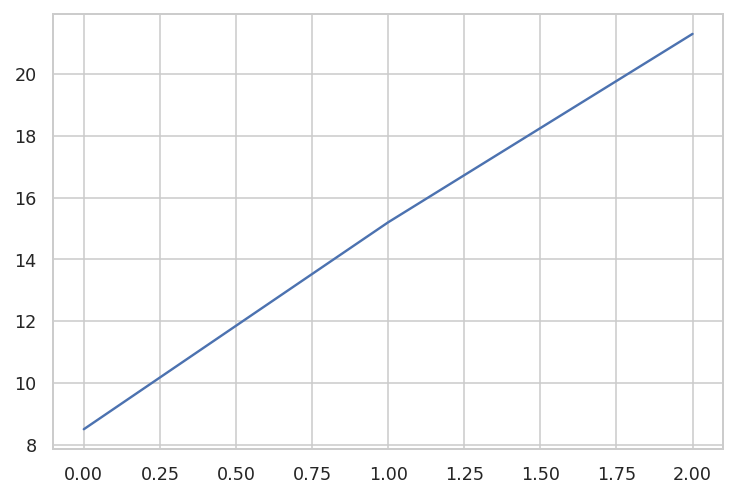

In [69]:
cum_var_exp = numpy.cumsum(numpy.round(pca.explained_variance_ratio_, decimals=3)*100)
plt.plot(cum_var_exp) ;